This notebook aims to classify drillers descriptions into lithological classes. Given the vagueness of classifying rocks with continuous properties into discrete classess as well as the inaccuracy of predictions we aim to use fuzzy theory to define the degree of class membership.

Here is a real example of a drillers description 'Clayey fine(0.5-2 mm) sand; yellow light brown, with 5% FeO cemented concretions, sample dry'. This description would likely lead a geologist to classify this interval as a sand with some clay. In a winner take all scheme we may classify the interval as a sand, but this simplification loses much of the detalil of the description. Maybe a class membership of 0.7 sand and 0.3 clay might be a better representation.

Neil Symington
neil.symington@ga.gov.au

In [14]:
import pandas as pd
import geopandas as gpd
import json
import os
import numpy as np
import re
import time
import sqlite3
import matplotlib.pyplot as plt
from shapely.wkb import dumps, loads
import shapely
from collections import Counter

In [3]:
# Define key functions

def add_to_dictionary(value, key, dictionary):
    """
    A function for appending an object to a dictionary
    entry
    
    @param value: object to be added to the dictionary
    @param key: dictionary key
    @dictionary: dictionary
    returns
    dictionary with added values
    """
    # Check if it already exists if so add nothing
    try:
        if values in dictionary[key]:
            return dictionary
        # Otherwise add the word
        else:
            dictionary[key] += [values]
            return dictionary
    except KeyError:
        dictionary[key] = [values]
        return dictionary

def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None

def keyword_frequency(string, kwords):
    """
    Function for counting the occurene of key words
    within a lithology description
    
    @param string: string from which to search for keywords
    @parma kwords: list of keywords
    keyword and the entries are a list of 'synonyms'
    returns
    
    dictionary with score denoting the number of times a
    key word was seen
    """
    # remove punctuation and split into list
    L = re.sub(r'[^\w\s]','', string).split()
    # make entirely lowercase
    L = [x.lower() for x in L]
    # Now use counter funtoin for performance
    c=Counter(L)
    
    newDict = dict.fromkeys(kwords, 0)
    # Iterate through words in description
    for item, count in c.items():
        # If the item is in the key word dict
        # then add the counted value to the new dictionary
        if item in kwords:
            # if the entry is in the kword dictionary
            # assign the item a 1 in newDict
            newDict[item] += count
    
    # Return the dictionary
    return newDict

In [4]:
# Open the key word dictionary from a json file produced in drillers_description_bag_of_words


filename = r"C:\Users\symin\OneDrive\Documents\GA\lithology_classification\NGIS_lithology_kwords_fuzzy.json"

with open(filename, 'r') as f:
    lithology_kwords = json.load(f)

# Or save
#with open(filename, 'w') as f:
    # Make sure the dictionary exists otherwise the json will be wiped
#    try:
#        lithology_kwords
#    except NameError:
#        print("Dictionary undefined")
#    else:
#        json.dump(lithology_kwords, f,
#                  indent=4, sort_keys=True)

In [5]:
# Here we are going to add some editting of this to produce adjective classes for lithologies (i.e. sandy, clayey)

new_kwords = ['sandy', 'silty', 'clayey']

for item in new_kwords:
    lithology_kwords[item] = []
    # Search corresponding entries for similar keywords
    prefix = item[:4]
    for entry in lithology_kwords[prefix]:
        if item in entry:
            lithology_kwords[prefix].remove(entry)
            lithology_kwords[item].append(entry)
    for entry in lithology_kwords[prefix + 'stone']:
        if item in entry:
            lithology_kwords[prefix + 'stone'].remove(entry)
            lithology_kwords[item].append(entry)
            
    

In [6]:
# Here we add some keywrods that were missed

lithology_kwords['unconsolidated'] = ['unconsolidated']
lithology_kwords['consolidated'] = ['consolidated']

In [7]:
print(lithology_kwords.keys())

dict_keys(['alluvium', 'amphibolite', 'angular', 'artificial', 'banded', 'basalt', 'bedrock', 'bioturbation', 'blotched', 'bluestone', 'breccia', 'brown', 'carbonate', 'cavity', 'cement', 'chalcedony', 'chert', 'clast', 'clay', 'clayey', 'claystone', 'coal', 'coarse', 'conglomerate', 'coral', 'cross-bedding', 'dark', 'deformation', 'diorite', 'dolerite', 'dolomite', 'dolostone', 'dropstone', 'dry', 'duricrust', 'fe oxides', 'fine', 'gneiss', 'grading', 'grained', 'grainsize', 'granite', 'gravel', 'grey', 'greywacke', 'groundwater', 'imbrication', 'intraclasts', 'ironstone', 'kaolinite', 'lag', 'lamination', 'laterite', 'light', 'limestone', 'lineation', 'loam', 'massive', 'matrix', 'medium', 'moderately', 'moist', 'mottled', 'mud', 'mudflakes', 'mudstone', 'orange', 'overbank', 'pegmatite', 'phyllite', 'pink', 'poorly', 'porcellanite', 'purple', 'quartz', 'quartzite', 'red', 'regolith', 'ripple', 'rock', 'root', 'rounded', 'sand', 'sandstone', 'sandy', 'schist', 'sediment', 'shale', 's

In [8]:
# Next we want a series of lists for how the keywords relate to the classes

# We will start with sediment vs consolidated rock

sediment = ['alluvium', 'gravel', 'sand', 'silt', 'clay', 'mud', 'loam', 'soil', 'regolith', 'unconsolidated'
           ]

rock = ['rock', 'bedrock', 'consolidated', 'granite', 'basalt', 'amphibolite', 'claystone', 'mudstone', 'siltstone',
       'sandstone', 'conglomerate']

In [27]:
# Now scrapte the NGIS database for additional lithologies

# This database is a copy of key tables for boreholes in the NGIS
# database that fall within the EFtF project areas
db = r"C:\GA\boreholes\Borehole_Data_Consolidation_CompositeLogs_NeilFork\EFTF_BH.sqlite"

conn = sqlite3.connect(db)

# Bring in the spatialite modules
os.environ['PATH'] = r'C:\Users\symin\mod_spatialite-NG-win-amd64\mod_spatialite-NG-win-amd64' + ';' + os.environ['PATH']
conn.enable_load_extension(True)
conn.execute('SELECT load_extension("mod_spatialite")')


# open the lithologies table using a sql qury in pandas
query = 'SELECT * from Lithology;'
df_ngis = pd.read_sql(query, conn)

sql = "SELECT uid, Hex(ST_AsBinary(Transform(geometry , 4283))) as geom FROM header;"

df_header = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col="geom")

In [15]:
# Now we will try the whole NGIS database. This takes some time

cols = rock + sediment

df_results = pd.DataFrame(columns = sediment + rock)

# Time the process
start_time = time.time()


# Iterate through the panda series
for index, string in df_ngis['l_Description'].dropna().items():
    # Get a dictionary with the word count for each keyword
    newDict = keyword_frequency(string, cols)
    # Append this to a dataframe with the same index as
    # the original data
    df_results = df_results.append(pd.DataFrame(newDict,
                                   index = [index]))
    
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


--- 494.39134883880615 seconds ---


In [25]:
# Join the results with the original frame to get the UID
# and then the depth top

df_results = pd.merge(df_results, df_ngis[['l_Description', 'l_ToDepth','uid']].dropna(),
                           left_index = True, right_index=True).drop_duplicates()

In [28]:
# Spit the table out to the database

df_results.to_sql('rock_sediment_keyword_frequency', conn, if_exists= 'replace', index=False,
                chunksize=100)


In [29]:
# Now lets sum the rock and sediment components for each row

df_results['rocksum'] = df_results[rock].sum(axis=1)
df_results['sedsum'] = df_results[sediment].sum(axis=1)

In [32]:
df_test=df_results[['rocksum', 'sedsum', 'l_ToDepth']]
df_test['difference'] = df_test['rocksum'] - df_test['sedsum']

C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
# LEts only look at the top 400 metres

df_test = df_test[df_test['l_ToDepth']  < 400]

In [18]:
criteria1 = (df_results['rocksum'] == 0)
criteria2 = (df_results['sedsum'] == 0)

In [51]:
# Just for fun lets say that the higher the sum of keywords
df_test= df_test[~criteria1][~criteria2]

C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


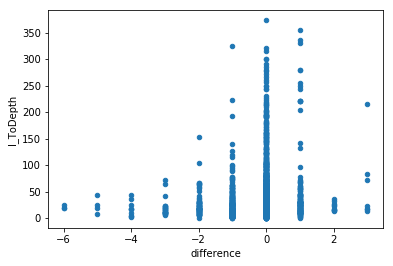

In [54]:
# Now lets plot difference vs depth

df_test.plot.scatter('difference', 'l_ToDepth')
plt.show()

In [70]:
inds = df_test[df_test['difference']==1].index
for i in range(10):
    print(df_ngis.loc[inds]['l_Description'].sample().item())
    print(' ')

Gravel sandstone and basalt with clasts up to 20mm in size
 
Sand and gravel; well rounded and poorly sorted grains from 1 mm to 4 cm. Gravels composed of black and pink sandstone, brown siltstone and granite.  Sample saturated.  Water sample taken at 24 m 680 Ás @ 25?c.
 
Gravel clasts of basalt sandstone andquartz predominatly up to 30 mm in size.  Rig chattering and partial loss of circulation.
 
Rock, sandstone & gravel
 
Rock, fractured sandstone, sand & water
 
Basalt, jaspilite, quartite, jaspilitic banded chert also sand 60% of which quartz 60% rest is feldspar-ilmenite(?) rock chips.  Heavy minerals present.  Minor possible garnets
 
Rock, grey clay, with soft siltstone
 
Grey rock, brown sandy clay, sandstone?
 
Grey rock, brown sandy clay, sandstone?
 
light brown and yellow sandstone with red brown siltstone and yellow clay
 
